In [1]:
%matplotlib inline
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import vdmlab as vdm
from analyze_maze import find_zones
from analyze_fields import get_unique_fields, categorize_fields
from analyze_tuning_curves import get_tc_1d, get_odd_firing_idx

In [2]:
from load_data import get_pos, get_spikes, get_lfp
import info.r063d2 as info

In [3]:
# pickle_filepath = 'C:/Users/Emily/Code/emi_shortcut/cache/pickled'
# output_filepath = 'C:/Users/Emily/Code/emi_shortcut/plots/sequence/'

pickle_filepath = 'E:/code/emi_shortcut/cache/pickled'
output_filepath = 'E:/code/emi_shortcut/plots/sequence/'

In [4]:
pos = get_pos(info.pos_mat, info.pxl_to_cm)
lfp = get_lfp(info.good_swr[0])
spikes = get_spikes(info.spike_mat)

In [5]:
times = info.task_times['phase3']

In [6]:
sliced_spikes = [spiketrain.time_slice(times.start, times.stop) for spiketrain in spikes]
sliced_pos = pos.time_slice(times.start, times.stop)

In [7]:
# plt.plot(sliced_pos.x, sliced_pos.y, 'g.', ms=2)
# plt.show()

In [8]:
binsize = 3
xedges = np.arange(sliced_pos.x.min(), sliced_pos.x.max() + binsize, binsize)
yedges = np.arange(sliced_pos.y.min(), sliced_pos.y.max() + binsize, binsize)

tc_filename = info.session_id + '_tuning-curve.pkl'
pickled_tuning_curve = os.path.join(pickle_filepath, tc_filename)
with open(pickled_tuning_curve, 'rb') as fileobj:
    tuning_curves = pickle.load(fileobj)
# tuning_curves = vdm.tuning_curve_2d(sliced_pos, sliced_spikes, xedges, yedges, gaussian_sigma=0.1)

In [9]:
xcenters = (xedges[1:] + xedges[:-1]) / 2.
ycenters = (yedges[1:] + yedges[:-1]) / 2.
xy_centers = vdm.cartesian(xcenters, ycenters)

In [10]:
zones = find_zones(info, expand_by=4)

field_thresh = 1.0
fields_tunings = categorize_fields(tuning_curves, zones, xedges, yedges, field_thresh=field_thresh)

In [11]:
u_line = LineString(info.u_trajectory)
shortcut_line = LineString(info.shortcut_trajectory)
novel_line = LineString(info.novel_trajectory)

In [12]:
u_dist = []
for neuron in fields_tunings['u']:
    yy = ycenters[np.where(fields_tunings['u'][neuron] == fields_tunings['u'][neuron].max())[0][0]]
    xx = xcenters[np.where(fields_tunings['u'][neuron] == fields_tunings['u'][neuron].max())[1][0]]

    pt = Point(xx, yy)
    if zones['u'].contains(pt):
        u_dist.append((u_line.project(pt), neuron))

In [13]:
ordered_dist_u = sorted(u_dist, key=lambda x:x[0])
sort_idx = []
for neuron in ordered_dist_u:
    sort_idx.append(neuron[1])

sort_spikes = []
sort_tuning_curves = []
for neuron in sort_idx:
    sort_tuning_curves.append(fields_tunings['u'][neuron])
    sort_spikes.append(spikes[neuron])
print(len(sort_spikes))

25


In [14]:
odd_firing_idx = get_odd_firing_idx(sort_tuning_curves, max_mean_firing=2)

In [15]:
ordered_spikes = []
ordered_fields =[]
for i, neuron in enumerate(sort_spikes):
    if i not in odd_firing_idx:
        ordered_spikes.append(neuron)
        ordered_fields.append(sort_tuning_curves[i])

In [16]:
print(len(ordered_spikes))

24


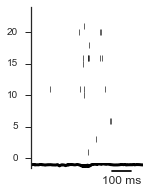

In [18]:
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')

# start_time = info.sequence['u']['run'].starts[0]
# stop_time = info.sequence['u']['run'].stops[0]

# start_time = info.task_times['phase2'].start + 170
# stop_time = info.task_times['phase2'].start + 210



def plot_sequence(ordered_spikes, lfp, start_time, stop_time, plot_name):
    ms = 6.
    mew = 0.6
    loc = 4
    spike_loc = 1

    rows = len(ordered_spikes)
    cols = 1
    fig = plt.figure(figsize=(2, 3))
#     fig = plt.figure()
    ax1 = plt.subplot2grid((rows+2, cols), (1, 0), rowspan=rows)
    ax2 = plt.subplot2grid((rows+2, cols), (rows+1, 0), sharex=ax1)

    for idx, neuron_spikes in enumerate(ordered_spikes):
        ax1.plot(neuron_spikes.time, np.ones(len(neuron_spikes.time))+(idx*spike_loc)-1, '|', 
                 color='k', ms=ms, mew=mew)
    ax1.set_xlim([start_time, stop_time])
    ax1.set_ylim([-0.5, len(ordered_spikes)*spike_loc])

#     start_idx = vdm.find_nearest_idx(lfp.time, start_time)
#     stop_idx = vdm.find_nearest_idx(lfp.time, stop_time)
#     ax2.plot(lfp.time[start_idx:stop_idx], lfp.data[start_idx:stop_idx]*8000-5, 'k', lw=1)
    
    ax2.plot(lfp.time, lfp.data*9000-5, 'k', lw=3)
    ax2.set_xlim([start_time, stop_time])
    ax2.set_ylim([np.min(lfp.data)-17, np.max(lfp.data)+3])

    vdm.add_scalebar(ax1, matchy=False, bbox_transform=ax1.transAxes, 
                     bbox_to_anchor=(1.0, -0.17), units='ms')

    plt.setp(ax1, xticks=[], xticklabels=[])
    plt.setp(ax2, xticks=[], xticklabels=[], yticks=[], yticklabels=[])


    sns.despine(bottom=True)

    plt.show()

#     savepath = output_filepath + info.session_id + plot_name + '.pdf'
#     plt.savefig(savepath, bbox_inches='tight', transparent=True)

#     savepath = output_filepath + info.session_id + plot_name + '.png'
#     plt.savefig(savepath, bbox_inches='tight', transparent=True)

# for idx in r067_idx:
#     print(idx)
#     start_time = decoded['decoded'].time[idx[0]]
#     stop_time = decoded['decoded'].time[idx[1]]
#     plot_sequence(ordered_spikes, lfp, start_time, stop_time, '-example_swr-sequence')

seq = 0
time = 'swr'
# start_time = 9133.55
# stop_time = 9134
start_time = info.sequence['u'][time].starts[seq]
stop_time = info.sequence['u'][time].stops[seq]
plot_sequence(ordered_spikes, lfp, start_time, stop_time, '-example_' + time + '-sequence')

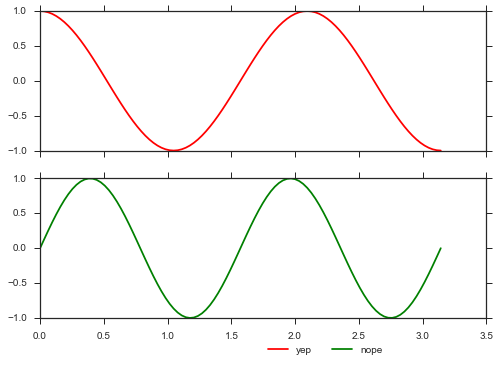

In [33]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

x = np.linspace(0, np.pi, 100)

line1, = ax1.plot(x, np.cos(3*x), color='red')
line2, = ax2.plot(x, np.sin(4*x), color='green')

# The key to the position is bbox_to_anchor: Place it at x=0.5, y=0
# in axes coordinates.
# "upper center" is basically saying center horizontal alignment and 
# top vertical alignment in this case
ax2.legend([line1, line2], ['yep', 'nope'], bbox_to_anchor=[0.5, -0.3], 
           loc=3, ncol=2, borderaxespad=0.1)

plt.show()

In [ ]:
info.session_id

In [ ]:
plt.close()

In [ ]:
# R068d2
start_time = decoded['decoded'].time[39760]
stop_time = decoded['decoded'].time[39765]
print(start_time, stop_time)

In [ ]:
r067_idx = [(6057, 6060), (10614, 10616), (11750, 11753), (18015, 18018), 
            (18894, 18898), (22253, 22257)]

In [ ]:
evt = 5
print(decoded['decoded'].time[r067_idx[evt][0]], decoded['decoded'].time[r067_idx[evt][1]])

In [ ]:
decode_filename = info.session_id + '_decode-tracks.pkl'
pickled_decoded = os.path.join(pickle_filepath, decode_filename)
with open(pickled_decoded, 'rb') as fileobj:
    decoded = pickle.load(fileobj)

In [ ]:
distance = np.diff(decoded['decoded'].time) > 0.025

In [ ]:
duration = 10
indexes = []
for i in range(len(distance)):
    if i+duration < len(distance):
        if distance[i:i+duration].all():
            indexes.append((i, i+duration))
len(indexes)

In [ ]:
len(distance)

In [ ]:
%matplotlib inline

xx, yy = np.meshgrid(xedges, yedges)
for key in fields_tunings['u']:
    print(key)
    pp = plt.pcolormesh(xx, yy, fields_tunings['u'][key], cmap='YlGn')
    plt.colorbar(pp)
    plt.axis('off')
    plt.show()

In [ ]:
info.task_times['phase2'].start + 130

In [ ]:
rows*cols

In [ ]:
len(tuning_curves)

In [ ]:
r068d2_fields = [2, 4, 5, 7, 8, 11, 14, 15, 
                 16, 18, 19, 24, 27, 30, 36, 38, 
                 43, 51, 54, 55, 57, 64, 69, 70, 
                 78, 81, 83, 85, 89, 91, 92, 93, 
                 96, 98, 101, 102, 105, 106, 109, 111]

In [ ]:
import matplotlib.gridspec as gridspec

u_line = LineString(info.u_trajectory)
shortcut_line = LineString(info.shortcut_trajectory)
novel_line = LineString(info.novel_trajectory)

rows = 8
cols = 5
fig = plt.figure(figsize=(12, 4))

grids = gridspec.GridSpec(cols, rows)
grids.update(wspace=0.02, hspace=0.02)

xx, yy = np.meshgrid(xedges, yedges)

for i, idx in zip(range(rows*cols), r068d2_fields):
    ax = plt.subplot(grids[i])
    pp = ax.pcolormesh(xx, yy, tuning_curves[idx], cmap='YlGn')
    ax.plot(u_line.xy[0], u_line.xy[1], 'k', lw=0.5)
    ax.plot(shortcut_line.xy[0], shortcut_line.xy[1], 'k', lw=0.5)
    ax.plot(novel_line.xy[0], novel_line.xy[1], 'k', lw=0.5)
    ax.axis('off')

# plt.show()

savepath = output_filepath + info.session_id + 'many_tuning-curves.pdf'
plt.savefig(savepath, dpi=600, bbox_inches='tight', transparent=True)

# saving many tuning curves same plot

In [ ]:
import matplotlib.gridspec as gridspec

rows = 8
cols = 14
fig = plt.figure(figsize=(10, 10))

grids = gridspec.GridSpec(cols, rows)
grids.update(wspace=0.02, hspace=0.05)

xx, yy = np.meshgrid(xedges, yedges)
for i in range(rows*cols):
    ax = plt.subplot(grids[i])
    pp = ax.pcolormesh(xx, yy, tuning_curves[i], cmap='YlGn')
    ax.axis('off')

savepath = 'E:/code/emi_shortcut/plots/tuning/' + info.session_id + 'many_tuning-curves.png'
plt.savefig(savepath, dpi=300, bbox_inches='tight')